In [ ]:
import os
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file
PROJECT_ROOT = Path(__file__).resolve().parent
load_dotenv(PROJECT_ROOT / ".env")

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_API_SECRET")

if not API_KEY or not API_SECRET:
    raise RuntimeError(
        "Missing Alpaca credentials. Set ALPACA_API_KEY and ALPACA_API_SECRET in the OS "
        "environment or create Stonks/trade_bot/.env with those keys."
    )

# Just import the 3 clients available
from alpaca.data import (
    CryptoHistoricalDataClient,
    StockHistoricalDataClient,
    OptionHistoricalDataClient,
)

# no keys required.
crypto_client = CryptoHistoricalDataClient()

# keys required
stock_client = StockHistoricalDataClient(API_KEY, API_SECRET)
option_client = OptionHistoricalDataClient(API_KEY, API_SECRET)


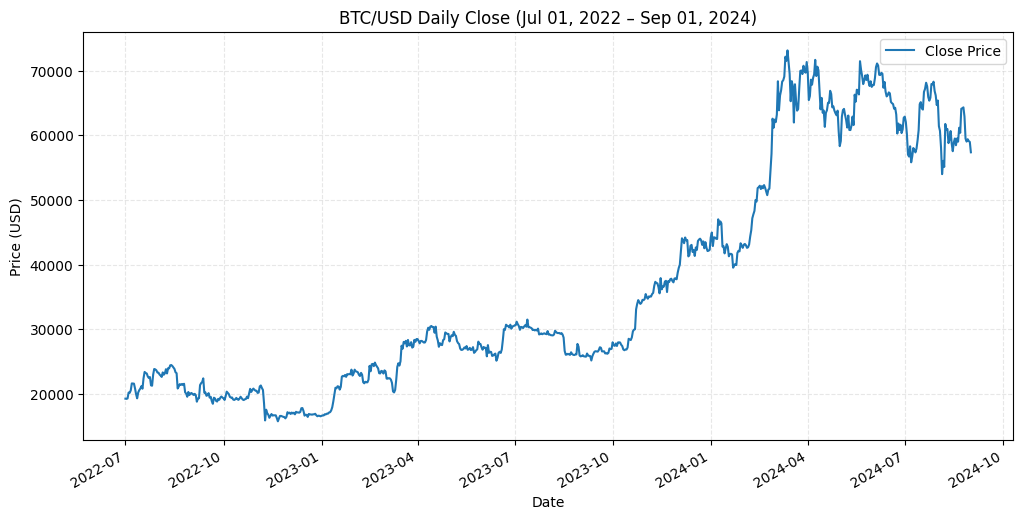

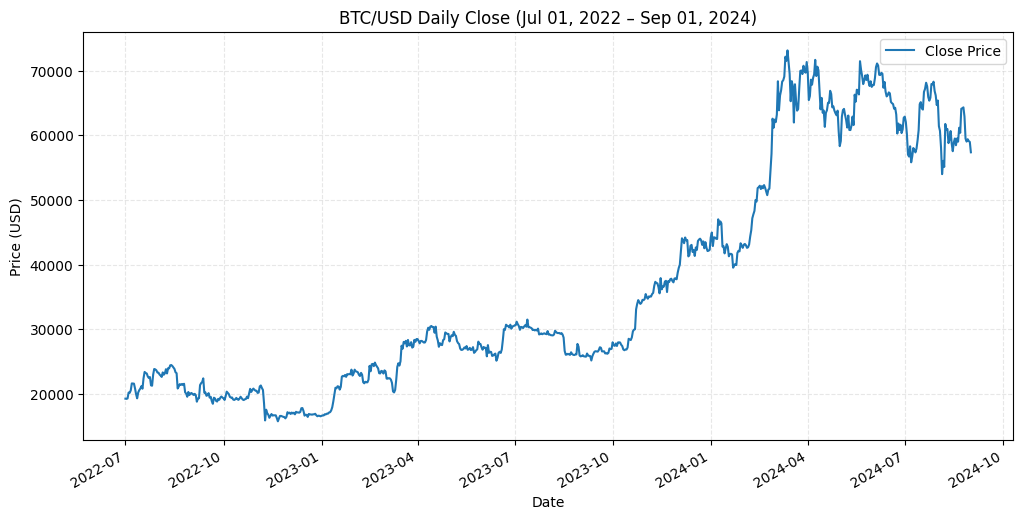

In [4]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Date range configuration
start_date = datetime(2022, 7, 1)
end_date = datetime(2024, 9, 1)
date_label = f"{start_date:%b %d, %Y} – {end_date:%b %d, %Y}"

# no keys required for crypto data
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD", "ETH/USD"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date,
)

bars = client.get_crypto_bars(request_params)

btc_bars = bars["BTC/USD"]

btc_df = pd.DataFrame(
    {
        "timestamp": [bar.timestamp for bar in btc_bars],
        "open": [bar.open for bar in btc_bars],
        "high": [bar.high for bar in btc_bars],
        "low": [bar.low for bar in btc_bars],
        "close": [bar.close for bar in btc_bars],
        "volume": [bar.volume for bar in btc_bars],
    }
).set_index("timestamp")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(btc_df.index, btc_df["close"], label="Close Price", color="tab:blue")
ax.set_title(f"BTC/USD Daily Close ({date_label})")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend()

fig.autofmt_xdate()
fig